In [ ]:
import warnings
import time
import pandas as pd
import numpy as np
warnings.simplefilter('ignore')

# Data_Base

### Paris has two main databases one recording Price and volume info of all frequencies, another recording all historical trading signals of all frequencies and all historical trades conducted

In [ ]:
Integrity = pd.read_csv('Data_Integrity.csv', index_col = 0)
Missing_Days = np.load('missing.npy', allow_pickle= True)
Gap_Dict = Missing_Days[()]
Gap_Dict['Daily']['GBPUSD']
Assets = pd.unique(Integrity.index)

In [ ]:
Assets

# Signal_Generator

### An application that generates all the trading signals, so far it contains 5 Technical Signals (MACD, RSI, BB, EMA and Acc_Dist) and 5 Machine Learning Signals (LASSO, Elastic Net, Neural Network, Support Vector and Random Forest). Signal Generator takes in price and generate either individual signals or all the signal at once by calling Generate_All_Signals(). 
### It is incorporated in the Back Testing Application and Live Trading Application, but it can be used individually too

In [ ]:
%run Database_Interactions.py
DB_Worker = DB_Operator('MT4_Database')
Frequencies = ['Minutely', 'Minutes_5', 'Minutes_15', 'Minutes_30', 'Hourly', 'Hours_4', 'Daily' , 'Weekly']
Refit = {'Minutely': 500, 'Minutes_5': 100, 'Minutes_15': 160, 'Minutes_30': 80, 
         'Hourly': 80, 'Hours_4': 80, 'Daily': 100, 'Weekly': 20}
#For Demonstration used one example and turned the refit to be infrequent
frequency = 'Daily'
Assets = ['GBPUSD']

In [ ]:
%run Signal_Pool.py
Collection = pd.DataFrame()
All = DB_Worker.read_entire_table(frequency)
All = All.set_index(pd.to_datetime(All['open_time'])).drop('open_time', axis = 1)
for asset in Assets:
    DataFrame = All[All['Asset'] == asset]
    Signal_Advisor = Generate_Signal(DataFrame)
    Signal = Signal_Advisor.Generate_All_Signals(All, Refit[frequency])
    Signal['Asset'] = asset
    Collection = pd.concat([Collection, Signal])

In [ ]:
Collection.loc['2018']

# Back_Testor

### Back_Testor is like the traffic center that connects with every other components. We specify what asset we want to trade on and how frequent we want our strategy to be as well as what signal we want to use. Back_Testor will then provide the performance of this strategy. It then uses the Risk Advisor and Performance Advisor to assess how risky and how good its performance was. When we're really happy about a strategy, we can choose to go live as the Back_Testor is connected with the Live Trading Assistant.

### Main Flexibilities include: 1. Signal importance, can specify Primary Signal against Ordinary Signals, can also specify how many signals need to agree before we take trades. 2. Weighting method, can choose to use equal weight (value), equal volatility weight, or other creative methods. 3. Exposure Control, allows cap on Portfolio and Individual levels Value and Volatility. 4. Time, can look at subset or full history

In [ ]:
Assets = ['BCOUSD', 'BTCUSD', 'CADJPY', 'WHEATUSD']
Frequency = 'Daily'
start = None
end = None
Signal_use = ['MACD', 'RSI', 'Acc_Dis']

In [ ]:
%run Back_Testor.py
Begining = time.time()
Portfolio = Backtestor(Assets, Frequency, start= start, end= end, Signal_use = Signal_use)

Portfolio.Set_Risk_Cap(Value_Cap = 100, Indiv_Value_Cap = 20, Volatility_Cap = 10, Indiv_Vol_Cap = 3)
Portfolio.Set_Signal_Rule(Primary = 'Acc_Dis', Agree = 1)

Benchmark = ['SPX500USD']
Factors_Interested = ['WTICOUSD', 'SPX500USD', 'GBPUSD', 'USB02YUSD']

Portfolio.run(Graphic = True, Factors = Factors_Interested, Benchmark= Benchmark)
print(time.time() - Begining, ' seconds to complete')

In [ ]:
%pylab qt
Portfolio.Risk_Demos()

In [ ]:
Portfolio.Performance_Demos()

# Risk_Advisor and Performance_Advisor

### Same old Risk and Performance Advisors we are familiar with, they are incorporated in the Back_Testor but of course both can be used separately to still give all the metrics. since they can cope with static information as well, they are connected to the Performance Advisor too

In [ ]:
Time = '2019-01-02'
frequency = 'Daily'
example_holding = Portfolio.Holdings.loc[pd.to_datetime(Time)].to_dict()
print(example_holding)

In [ ]:
%run Risk_Analytics_App.py
My_Advisor = Risk_Advisor(Graphic= True)

In [ ]:
My_Advisor.Risk_Contribution()

# Live_Trading Assistant

### Live Assistant take the task of communicating with the MT4 platform, 1. constantly requesting current portfolio holding and use Risk/ Performance Advisor to assess the current holding. 2. constantly pooling live-stream price info and connects with the signal generator to get trading signal. 3. Execute the order if signal appears

In [1]:
import warnings
#warnings.simplefilter('ignore')
%run Live_Trading_App.py
Trader_Advisor = Live_Trade_App(Update_Frequency = 7, _Time_Out = 3)

Good morning sir, PARIS is online 


In [2]:
#%pylab qt
Trader_Advisor.Run()

{'Cash': -572846.93, 'WTICOUSD': -10.0, 'GBPUSD': 10000.0, 'USDCHF': -10000.0, 'USDJPY': 10000.0, 'US30USD': -10.0, 'EURUSD': -10000.0, 'XAUUSD': 10.0, 'DE30EUR': -10.0, 'AUDUSD': 10000.0}


Exception in thread Risk Updater:
Traceback (most recent call last):
  File "C:\Users\Hli\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\Users\Hli\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Hli\Desktop\AP\Live_Trading_App.py", line 110, in _Risk_Monitor
    plt.pie(out3.values, labels= list(out3.columns), autopct='%1.1f%%')
  File "C:\Users\Hli\Anaconda3\lib\site-packages\matplotlib\pyplot.py", line 2803, in pie
    data is not None else {}))
  File "C:\Users\Hli\Anaconda3\lib\site-packages\matplotlib\__init__.py", line 1810, in inner
    return func(ax, *args, **kwargs)
  File "C:\Users\Hli\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py", line 2810, in pie
    raise ValueError("'label' must be of length 'x'")
ValueError: 'label' must be of length 'x'



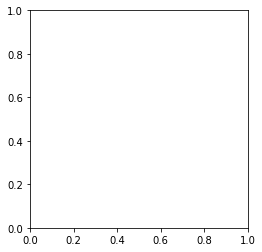

In [3]:
Trader_Advisor._Close_Market()

In [7]:
x = Trader_Advisor._Online_Auditor.Risk_Contribution(latest= False)

In [31]:
x.loc['live']

WTICOUSD    0.000015
GBPUSD     -0.010194
USDCHF     -0.001957
USDJPY      0.471552
US30USD     0.346360
EURUSD      0.003279
XAUUSD     -0.005782
DE30EUR     0.193072
AUDUSD      0.003656
Cash       -0.000000
Name: live, dtype: float64

In [ ]:
Check = 'GBPUSD'
Trader_Advisor._Snapshots(30, Check)

In [ ]:
Trader_Advisor.Print_Price_Buffer()

In [ ]:
Trader_Advisor.Assistant._DWX_ZMQ_HEARTBEAT_()

In [ ]:
Trader_Advisor.Assistant._get_response_()